In [1]:
import pandas as pd
import bs4 as bs
import urllib.request
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,hamming_loss
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

from urllib.request import Request, urlopen
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

from bokeh.io import show
from bokeh.models import LogColorMapper
from bokeh.palettes import gray
from bokeh.plotting import figure
import shapely

## Data upload

We will start by scraping all the jobs postings on the StackOverflow job board. This webpage is static and we can easily save skills and titles into a new dataframe. Salary and location are not always mentioned, but we will fetch them and later see if they have enough data for any conclusions. For this we will use Beautifulsuop: 

In [85]:
df = pd.DataFrame(columns=['job_title', 'skills', 'pay', 'Country'])
i=0
for j in range(1,178):
    if j==1:
        source = urllib.request.urlopen('https://stackoverflow.com/jobs').read()
        soup = bs.BeautifulSoup(source,'lxml')
    else:
        uerel='https://stackoverflow.com/jobs?sort=i&pg='+str(j)
        source = urllib.request.urlopen(uerel).read()
        soup = bs.BeautifulSoup(source,'lxml')
    listing = soup.find('div', attrs={'class':'listResults'})
    listitems = listing.find_all('div', attrs={'class':'-job-summary'})
    for item in listitems:
        titlehtml=(item.find('div', attrs={'class':'-title'})).find('a', attrs={'class':'s-link s-link__visited'})
        title=titlehtml.contents
        try:
            tagshtml=(item.find('div', attrs={'class':'mt12 -tags'})).find_all('a', attrs={'class':'post-tag job-link no-tag-menu'})
            l=[]
            for skill in tagshtml:
                l.append(skill.contents[0])
        except:
            l=None
        try:
            tahrev=(item.find('div', attrs={'class':'mt2 -perks'})).find('span', attrs={'class':'-salary pr16'}).contents[0]
            r=(tahrev.split(' ')[0].replace('k','000'))
            r=r.replace('£','').replace('€','').replace('$','')
            pl=float(r)*1.2
            r=pl
        except:
            r=None
        try:
            country=(item.find('div', attrs={'class':'fc-black-700 fs-body2 -company'})).find_all('span', attrs={'class':'fc-black-500'})
            c=country.split(', ')[1].split(' ')[0]
        except:
            c=None
        df.loc[i] = [title[0], l, r, c]
        i+=1
        
df.info()
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4425 entries, 0 to 4424
Data columns (total 4 columns):
job_title    4425 non-null object
skills       4365 non-null object
pay          532 non-null float64
Country      0 non-null object
dtypes: float64(1), object(3)
memory usage: 172.9+ KB


,job_title,skills,pay,Country
0,Lead Frontend Engineer - React (m/f/x),"[reactjs, javascript, html, frontend, react-re...",NaN,None
1,Desarrollador/a ETL (Talend),[etl],NaN,None
2,"Backend (PHP, Wordpress, Prestashop developer)","[php, wordpress]",NaN,None
3,Senior JavaScript Developer (m/f/d),"[javascript, cloud, html, css, node.js]",NaN,None
4,Salesforce Commerce Cloud Developer (m/f/d),"[html, css, javascript, isml]",NaN,None
5,Team Lead Engineering,"[agile, java, mysql]",NaN,None
6,Technical Director,"[agile, java, mysql]",NaN,None
7,Analista digital - Business Intelligence,None,NaN,None
8,Senior Frontend Engineer - React (m/f/x),"[reactjs, javascript, html, frontend, react-re...",NaN,None
9,AEM Backend Developer (f/m/d) - revolutionize ...,"[java, sling, crx, osgi, aem]",66000.0,None


Now, for more data we will be scraping Monster job portal. This webpage is dynamical, so we will turn to using selenium. We can manually order the driver to wait for the script to load, and then scape the newly made HTML:

In [95]:
for j in range(1,150):
    if j==1:
        uerel='https://www.monsterindia.com/search/results?sort=1&limit=100&query=Programming'
    else:
        k=(j-1)*100
        uerel='https://www.monsterindia.com/search/results?start='+str(k)+'&sort=1&limit=100&query=Programming'
    driver = webdriver.Chrome(executable_path='chromedriver.exe')
    driver.implicitly_wait(1000)
    driver.get(uerel)
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    listing = soup.find('div', attrs={'class':'srp-left'})
    listitems = listing.find_all('div', attrs={'class':'card-apply-content'})
    for item in listitems:
        titlehtml=(item.find('div', attrs={'class':'job-tittle'})).find('h3')
        title=titlehtml.contents
        l=[]
        try:
            tagshtml=(item.find('p', attrs={'class':'descrip-skills'}))
            l.extend(tagshtml.contents[1].strip().split(','))
        except:
            l=None
        if isinstance(l,list):
            l=str(l)
        try:
            tahrev=(item.find('div', attrs={'class':'searctag row'})).find('div',attrs={'class':'package col-xxs-12 col-sm-4 text-ellipsis'}).find('span', attrs={'class':'loc'}).find('small').contents[0]
            r=(tahrev.replace('\n','').split('-'))[0].strip()
            pl=float(r)*0.014
            r=pl
        except:
            r=None
        try:
            country=((item.find('div', attrs={'class':'searctag row'})).find('span', attrs={'class':'loc'})).find('small').contents
            c=country[0].replace('\n','').strip().split(',')[-1].strip()          
        except:
            c=None
        df.loc[i] = [title[0], l, r, c]
        i+=1

df.to_csv('final2.csv', sep='\t', encoding='utf-8')


,job_title,skills,pay,Country
0,Lead Frontend Engineer - React (m/f/x),"[reactjs, javascript, html, frontend, react-re...",NaN,None
1,Desarrollador/a ETL (Talend),[etl],NaN,None
2,"Backend (PHP, Wordpress, Prestashop developer)","[php, wordpress]",NaN,None
3,Senior JavaScript Developer (m/f/d),"[javascript, cloud, html, css, node.js]",NaN,None
4,Salesforce Commerce Cloud Developer (m/f/d),"[html, css, javascript, isml]",NaN,None
5,Team Lead Engineering,"[agile, java, mysql]",NaN,None
6,Technical Director,"[agile, java, mysql]",NaN,None
7,Analista digital - Business Intelligence,None,NaN,None
8,Senior Frontend Engineer - React (m/f/x),"[reactjs, javascript, html, frontend, react-re...",NaN,None
9,AEM Backend Developer (f/m/d) - revolutionize ...,"[java, sling, crx, osgi, aem]",66000.0,None


For reading the DataFrame from written csv file:

In [13]:
df=pd.read_csv('final2.csv', sep='\t', encoding='utf-8')
df=df[['job_title', 'skills', 'pay', 'Country']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19125 entries, 0 to 19124
Data columns (total 4 columns):
job_title    19125 non-null object
skills       19063 non-null object
pay          3094 non-null float64
Country      14700 non-null object
dtypes: float64(1), object(3)
memory usage: 597.7+ KB


We use the dropna() function to permanently erase all columns or rows that contain empty values. Country and salary is sparse information on scraped jobportals and we will not be dropping them. As we are interested in predicting skills jobs, we have to clean the data from empty skillsets.


In [14]:
df.dropna(subset=['skills'], inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 19063 entries, 0 to 19124
Data columns (total 4 columns):
job_title    19063 non-null object
skills       19063 non-null object
pay          3083 non-null float64
Country      14698 non-null object
dtypes: float64(1), object(3)
memory usage: 744.6+ KB


As we can see, 62 job postings have been dropped. Inspecting how the data looks:

In [15]:
df.head()

,job_title,skills,pay,Country
0,Lead Frontend Engineer - React (m/f/x),"['reactjs', 'javascript', 'html', 'frontend', ...",NaN,NaN
1,Desarrollador/a ETL (Talend),['etl'],NaN,NaN
2,"Backend (PHP, Wordpress, Prestashop developer)","['php', 'wordpress']",NaN,NaN
3,Senior JavaScript Developer (m/f/d),"['javascript', 'cloud', 'html', 'css', 'node.js']",NaN,NaN
4,Salesforce Commerce Cloud Developer (m/f/d),"['html', 'css', 'javascript', 'isml']",NaN,NaN


## Exploring data and preprocessing
In this task we are interesting in predicting most probable skills required for some input job. Different job titles are associated with different number of skills and these skills are represented in lists. Since these skills are not mutually exclusive this is a problem of multi-label classification.


#### job titles
Starting from the *job_title*, we apply different preprocessing methods. This is necessary since different machine learning models cannot see a similarity between words as humans can. For data to be machine readable, it should be clear from special characters and words that dont have a significant meaning in future predictions. For example, stop words like 'the', 'an' etc. bear no meaning for predictions. Stemming and lemmatization rid words of unnecessary suffixes or prefixes and reduce it to their roots because e.g. 'working' has the same meaning as 'work'. 

Also, looking at the data we can see a lot of special characters. Example given, an input (C++/C# Developer;	skills: c++, c#;) could, if feeded to an algorithm, be interpreted as C++/C# being a one word when it is clearly meant to represent a developer with knowledge in both languages. Another example is nonidentical spelling Full-stack and Full Stack of the same concept. We will handle this by replacing methods and splitting these in multiple words. 

In [16]:
stop_words = text.ENGLISH_STOP_WORDS

def preproces(tekst):
    #removing special characters
    unwanted_chars=['/', '-', '_', '(', ')', '&', '|', '*', ',', '%', '$', '~', '<', '>', '@', '[', ']', '^', ':', ';', '?', '!']
    for char in tekst:
        if char in unwanted_chars:
            tekst = tekst.replace(char,' ')
    
    #removing complete words from the list of english stop words
    tekstlist=tekst.split()
    for word in tekstlist[:]:
        if word in stop_words:
            tekstlist.remove(word)
   
    tekst=' '.join(tekstlist)
    
    #lowercasing all titles because of case sensitivity
    tekst = tekst.lower()
    #stripping text of unnecessary white spaces
    tekst=tekst.strip()
    return tekst

df['job_title'] = df['job_title'].apply(preproces)

For stop words removal we used a set of 318 words in the English language. We didn't erase #, + and . characters as they have a particular meaning for some jobs/skills (e.g. C#, node.js). Since we are dealing with occupations that usually have the -er suffix we will not stem our job titles. An example of cleaned text and the complete set of used stop words can be seen by uncommenting code in the next cell:

In [23]:
#tekst='  therefore Mary and ,Samantha       arrived$ at$ the bus [station] before noon  ~@  '
#print(preproces(tekst))
#print(stop_words)

We can easily check if our preprocessing method worked on our dataframe by glancing at the first five rows again with head() function.

In [10]:
df.head()

,job_title,skills,pay,Country
0,lead frontend engineer react m f x,"['reactjs', 'javascript', 'html', 'frontend', ...",NaN,NaN
1,desarrollador etl talend,['etl'],NaN,NaN
2,backend php wordpress prestashop developer,"['php', 'wordpress']",NaN,NaN
3,senior javascript developer m f d,"['javascript', 'cloud', 'html', 'css', 'node.js']",NaN,NaN
4,salesforce commerce cloud developer m f d,"['html', 'css', 'javascript', 'isml']",NaN,NaN


#### skills
Now, we can take a look at our second column containing skill tags for the corresponding job titles. First, we can explore which skills are contained and how many of them are unique. Hereinafter, by 'skill combination' we mean a particular *set* of skills e.g. a triple item set of c# *and* java *and* react.js, whereas by 'skill' we mean a single skill e.g. react.js.

We will find the number of unique skill combination as well the number of skills.

In [17]:
uniq_skill_combination=df['skills'].unique()
print('Number of unique items in column skills: {}'.format(len(uniq_skill_combination)))
print('First ten skill combinations:')
print(uniq_skill_combination[:10])

Number of unique items in column skills: 11444
First ten skill combinations:
["['reactjs', 'javascript', 'html', 'frontend', 'react-redux']" "['etl']"
 "['php', 'wordpress']"
 "['javascript', 'cloud', 'html', 'css', 'node.js']"
 "['html', 'css', 'javascript', 'isml']" "['agile', 'java', 'mysql']"
 "['java', 'sling', 'crx', 'osgi', 'aem']" "['qa', 'selenium', 'testing']"
 "['c#', '.net', 'design']" "['oracle', 'sql']"]


Data organised like this bears no value as it cannot be deducted how frequent particular _unique_ skills are or with which titles do they pair. Also, the upper method unique() will not recognise lists with same skills that are ordered differently. We will build our own function to calculate their frequencies:

In [18]:
def skill_frequencies(datafr):
    dictuniq = {}
    lengthfreq = {}
    for index, ser in datafr.iterrows():
        if len(eval(ser['skills'])) in lengthfreq:
                lengthfreq[len(eval(ser['skills']))] += 1
        else:
                lengthfreq[len(eval(ser['skills']))] = 1
        for item in eval(ser['skills']):
            if item in dictuniq:
                dictuniq[item] += 1
            else:
                dictuniq[item] = 1
    return dictuniq, lengthfreq


dict_uniq, length_freq=skill_frequencies(df)
print('Number of unique skills: {}'.format(len(dict_uniq)))

Number of unique skills: 16815



 
Alongside determining these numbers we also found the frequency of skill combination length (i.e. for how many job titles are N skills required). Casting these numbers to Series objects for easier work and sorting them gives us an insight to most wanted skills and number of skills known:

In [19]:
#this kind of sorting doesnt affect our original series objects

skill_series=pd.Series(dict_uniq)
print('Most wanted job skills:')
print(skill_series.sort_values(ascending=False)[:5])

print('\nNumber of skill sets per their length:')
print(pd.Series(length_freq).sort_values(ascending=False)[:5])

Most wanted job skills:
java           1219
 Javascript     698
javascript      646
Java            643
python          591
dtype: int64

Number of skill sets per their length:
1    4421
3    3580
5    2295
4    1631
2    1570
dtype: int64


It's visible that the most wanted skill is java which is also the most popular skill
, and overall we can say that the majority of job titles require a small (less than 4) set of different skills.

It can be immediately seen that our skills series need preprocessing! The first two skills represent the same item, javascript. We will not be dropping most characters as they represent value in programming skill terms, but need to lowercase and preprocess as we did with titles. We can't explore frequencies before having clean data.

For the upcoming analysis it will be more convenient to work with strings describing skills rather than lists. We will reshape our *skills* column to contain skills separated by whitespaces:

In [20]:

def list_to_string(lista):
    stri=''
    for i in eval(lista):
        stri=stri+i+" "
    stri=stri.strip()
    return stri

df['skills']=df['skills'].apply(list_to_string)
df['skills'] = df['skills'].apply(preproces)
df.head() #quick check of reshape success

,job_title,skills,pay,Country
0,lead frontend engineer react m f x,reactjs javascript html frontend react redux,NaN,NaN
1,desarrollador etl talend,etl,NaN,NaN
2,backend php wordpress prestashop developer,php wordpress,NaN,NaN
3,senior javascript developer m f d,javascript cloud html css node.js,NaN,NaN
4,salesforce commerce cloud developer m f d,html css javascript isml,NaN,NaN


Now we can check the frequency of wanted skills as our skills set is clean. First ten most popular skills are:

In [21]:
skill_fr=df['skills'].str.split(expand=True).stack().value_counts()
skill_fr[:10]

java          4049
developer     3566
software      2520
sql           2215
engineer      2087
it            2062
web           1706
data          1695
javascript    1596
c#            1407
dtype: int64

easily plotable by:

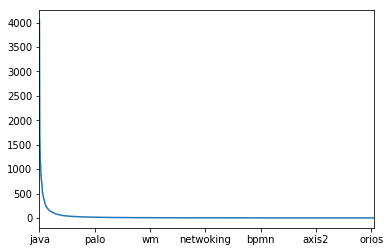

In [65]:
skill_fr.plot()

We can see that a large number of various skills that weren't abundant in over 19000 job posting skew our data. Actually out of 6053 skills, 1967 appeared only once!

In [22]:
skill_fr.where(skill_fr==1).count()

1967

We will visualize just the first few highly mentioned (over 1000 time through the dataset):

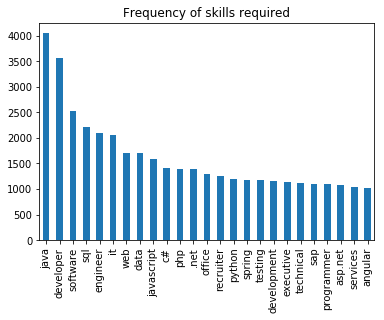

In [23]:
#visualizing popularity of different skills
skill_fr[skill_fr.values>1000].plot(kind='bar', title='Frequency of skills required')


#### Creating dummy variables
When dealing with multi-label classification, our targets represent properties of the data we are interpreting, and these properties are what we are trying to predict. In this particular case they are job-related skills. Since they are a final countable set of categorical data, we will reshape them to binary dummy variables using One Hot Encoding. This method attaches a 1 if the skill is required or a 0 if the skill is not mentioned for every job title entry. This is necessary since machine learning algorithms work better (or only) with binary data. We expect to construct a mxn dataframe (n possible skills for every of m dataframe entries). 


In [ ]:
dfskill=pd.DataFrame(columns=dict_uniq.keys())

for x in range( df.shape[0] ): #for every entry in the original dataframe
    someDict={}
    for item in dict_uniq.keys(): #for every unique skill there is
        rowdata=df.iloc[x]['skills'] #catch the information in the skills column of the row x
        if item in rowdata:
            someDict[item]=1 #if the skill is contained mark it with 1 and add it to a dictionary
        else:
            someDict[item]=0
    dfskill=dfskill.append(someDict,ignore_index=True) #append the information from this dictionary to the skills dataframe, for each row
    

In [ ]:
dfskill.to_csv('dummy.csv')

In [13]:
print('The newly constructed dataframe containing binary values for every skill is of shape: {}'.format(dfskill.shape))

The newly constructed dataframe containing binary values for every skill is of shape: (1218, 390)


It is indeed of the right shape. Checking how the dummy variables look like:

In [14]:
dfskill.head()

,java,python,sql,reactjs,linux,sql-server,cloud,r,embedded,project-management,...,angular7,angular5,powerbi,rds,openfoam,postgres,dba,wordpress,moodle-vle,mongo
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Not to change anything in the original dataframe, we will create a hard copy of it in which we will drop the now redundant skill column. Afterwards, we will attach the created dummy variables to it. 

In [15]:
dftitle=df.copy()
dftitle.drop(['skills'], axis=1, inplace=True) #dataframe containing job titles and ids
dffin=dftitle.join(dfskill, how='left')
dffin.shape

(1218, 391)

In [16]:
#checking the shape and the final dataframe
print('Shape od input dataframe: {}'.format(dffin.shape))
dffin.head()

Shape od input dataframe: (1218, 391)


,job_title,java,python,sql,reactjs,linux,sql-server,cloud,r,embedded,...,angular7,angular5,powerbi,rds,openfoam,postgres,dba,wordpress,moodle-vle,mongo
0,quorum blockchain engineer,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,software engineer,0,1,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,sql database administrator,0,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,cloud engineer,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,senior data engineer,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
dffin.dropna(inplace=True)
dffin.shape

(1211, 391)

In [18]:
ser=(dffin.drop(['job_title'], axis=1)).sum(axis=0) > 5
ser['job_title']=True
dffin=dffin[dffin.columns[ser]]


## Prediction models

This data will be the input for the machine learning models. Since we are interesting in predicting skills based on a job title, our skills binary variables are the target. We can feed now processed and reshaped data to different algorithms.  Before making predictions we have to choose the algorithm. 

Different algorithms for multi-label classification that can process text mostly differ by the way they treat input data, in this particular case job titles. These titles can for example be treated as independant combinations of words with same importance, or contrary to that they can get assigned significance to different words - based on their frequency or position where they occurred.
A very popular method to handle text is Term Frequency — Inverse Data Frequency (or Tf-idf) which assigns weight factors to words based on the number of times they appeared in the document. Generally, stop words occurr with highest frequencies in documents and Tf-idf penalizes them. This is usually very convenient, but in our notebook we already cleared job titles from them. For other words, it constructs a matrix with numbers depicting their relevancy. 

To start we should first determine training and testing data:

In [19]:
#selecting input and targets and splitting the data for training and testing
X = dffin['job_title']
y = dffin.drop(['job_title'], axis=1)

#note: we could have used dftitle and dfskill for x and y, we are using a common dataframe for the process to be more intelligible

#splitting data into training and testing sets by 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape) #checking the shapes

Tf-idf vectorizer transformed input job titles to a matrix of over two thousand weighting values for each entry. 

In [ ]:
vect = TfidfVectorizer()
Xtransf = vect.fit_transform(X_train)
Xtransf_test = vect.transform(X_test)
print(Xtransf.shape)

#### Logistic Regression

Our first model will be Logistic Regression, a very simple model in which we predict True or False for each of the properties. 

For each skill from the dataset we need to calculate predictions separately. We will feed metric scores to a dictionary under the key of the corresponding skill:

In [ ]:
classifier = LogisticRegression()
predictionprobabilities=pd.DataFrame()
metricsdict={'skill':0}
for skill in y.columns:
    yskill = y_train[skill]
    yskillt=y_test[skill]
    classifier.fit(Xtransf.astype(float), yskill.astype(float))
    predictions = classifier.predict(Xtransf_test.astype(float))
    predictionprobabilities[skill]=classifier.predict_proba(Xtransf_test)[:,1]
    #metricsdict[skill]=[accuracy_score(yskillt.astype(float), predictions.astype(float)), precision_score(yskillt.astype(float), predictions.astype(float)),recall_score(yskillt.astype(float), predictions.astype(float)), hamming_loss(yskillt.astype(float), predictions.astype(float))]
    
del metricsdict['skill']
#print(metricsdict)

If we want to check the probabilities of some input job title, we ought to first vectorize this input in the same manner as we did for our training and testing set. If we for example type 'java engineer' we can see the vectorizer again transformed it into a matrix with the same number of weighting values, now just one dimensional:

*You can use the cell below to find out most probable skill for any arbitrary input*

In [ ]:
#input job title of interest
string=input()
strings=pd.Series([string]) 
inputtitle = vect.transform(strings)
print('Shape of vectorized input: {}'.format(inputtitle.shape))

#dictionary of probabilities and list with predicted skills index
def predictskills(classifier,y,y_train,Xtransf, inputtitle):
    probdict={'skill':0}
    outputlist=[]
    for skill in y.columns:
        yskill = y_train[skill]
        classifier.fit(Xtransf.astype(float), yskill.astype(float))
        if classifier == LogisticRegression():
            probdict[skill]=classifier.predict_proba(inputtitle)
        outputlist.append(classifier.predict(inputtitle)[0])
    del probdict['skill']

    outputskill=[]
    for i in range(len(outputlist)):
        if outputlist[i].astype(float)==1:
            outputskill.append(y.columns[i])
    return 'Most probable skills for {} job title: {}'.format(string, outputskill)
print(predictskills(classifier,y,y_train,Xtransf, inputtitle))


We have found the most probable skills in completely the same manner as in the cell previous to it. If we want to inspect metrics for each individual skill predictions we can call metricsdict which contains accuracy, precision, recall and hamming loss.

More relevant to this type of problems is the hamming score. We are using the hamming_loss function from sklearn metrics:

In [ ]:
#example of hamming loss for javascript skill
metricsdict['javascript'][-1]

This metric presents rate of missed labels that sould be predicted, so a lower score means better performance.

Now, we can choose any classifier we find fit for this problem, overwrite these predictions and inspect the metrics:

#### One versus Rest
This classification fits data to one category of targets against all the others. The process is repeated for every category  and probabilities are chosen based on confidence values. 


In [ ]:
classifier = OneVsRestClassifier(LinearSVC())

metricsdictovr={'skill':0}
for skill in y.columns:
    yskill = y_train[skill]
    yskillt=y_test[skill]
    classifier.fit(Xtransf.astype(float), yskill.astype(float))
    predictions = classifier.predict(Xtransf_test.astype(float))
    #metricsdictovr[skill]=[accuracy_score(yskillt.astype(float), predictions.astype(float)), precision_score(yskillt.astype(float), predictions.astype(float)),recall_score(yskillt.astype(float), predictions.astype(float)), hamming_loss(yskillt.astype(float), predictions.astype(float))]
    
del metricsdictovr['skill']
#print(metricsdictovr)
print(predictskills(classifier,y,y_train,Xtransf, inputtitle))

#### Tree Classification
Decision trees can be used for multi-label problems in a way that each node is splitted based on a decision that is of binary nature i.e. each node can only assign values of True and False (or 1 and 0).

In [ ]:
classifier=DecisionTreeClassifier()

metricsdicttree={'skill':0}
for skill in y.columns:
    yskill = y_train[skill]
    yskillt=y_test[skill]
    classifier.fit(Xtransf.astype(float), yskill.astype(float))
    predictions = classifier.predict(Xtransf_test.astype(float))
    #metricsdicttree[skill]=[accuracy_score(yskillt.astype(float), predictions.astype(float)), precision_score(yskillt.astype(float), predictions.astype(float)),recall_score(yskillt.astype(float), predictions.astype(float)), hamming_loss(yskillt.astype(float), predictions.astype(float))]
    
del metricsdicttree['skill']
#print(metricsdicttree)
print(predictskills(classifier,y,y_train,Xtransf, inputtitle))

We will compare our three approaches by inspecting the accuracy and hamming loss of skills. Sum of these metrics can be used because mean values would be sums divided by number of skills, which is the same for every predictor.

In [ ]:
def sumofhamloss(metricsdictionary):
    sum=0
    for skill,values in metricsdictionary.items():
        sum+=values[-1]
    return sum
def accuracysum(metricsdictionary):
    sum=0
    for skill,values in metricsdictionary.items():
        sum+=values[0]
    return sum
print('Logistic Regression:\nSum of hamming loss of every skill: {}\nSum of accuracy for every skill: {}'.format(sumofhamloss(metricsdict), accuracysum(metricsdict)))
print('One-vs-Rest:\nSum of hamming loss of every skill: {}\nSum of accuracy for every skill: {}'.format(sumofhamloss(metricsdictovr), accuracysum(metricsdictovr)))
print('Tree:\nSum of hamming loss of every skill: {}\nSum of accuracy for every skill: {}'.format(sumofhamloss(metricsdicttree), accuracysum(metricsdicttree)))

        

We are interested in *higest* accuracy and *lowest* hamming score, therefore our optimal classifier out of three tested is the first one - Logistic Regression, for which we have already developed a predictor of skills for an input job title. It should also be noted it is the fastest. By choosing it as our best model we can conclude this task.

In [ ]:
df.groupby('Country')

We can also look for salaries among different countries. For visualization, we will import countries coordinates from a public list:

In [ ]:
import geopandas as gpd
countries = 'ne_110m_admin_0_countries.shp'
gdf = gpd.read_file(countries)[['ADMIN','geometry']]
gdf.columns = ['Country','shape']

If we're itnerested how salaries move in countries of different GDPs, we can scrape that data of from Wikipedia:

In [ ]:
source = urllib.request.urlopen('https://en.wikipedia.org/wiki/List_of_sovereign_states_in_Europe_by_GDP_(PPP)_per_capita').read()
soup = bs.BeautifulSoup(source,'lxml')

table = soup.find('table', attrs={'class':'sortable wikitable'})
table_rows = table.find_all('tr')

res = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td if tr.text.strip()]
    if row:
        res.append(row)


gdp = pd.DataFrame(res, columns=["Rating","Country", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019"])
gdp=gdp.drop('Rating', axis=1)
gdp.set_index('Country',inplace=True)


def toint(string):
    stri=string.replace(',','')
    return int(stri)
gdp=gdp.applymap(lambda x: toint(x))

In [ ]:
gdpf=gdf.merge(gdp[['2018', '2019']], on='Country')


And finally, make a dataframe containing the mean salary, gdp and its location. 

In [ ]:
cntpy=df.groupby(['Country']).mean()
cntpy = cntpy.merge(gdpf,how = 'left', on = 'Country') 

In [ ]:
def politoall(poly):
    a=[]
    if poly.type == 'MultiPolygon':
        allparts = [p.buffer(0) for p in poly]
        #poly = shapely.ops.cascaded_union(allparts)
        for p in poly:
            a.extend(p.exterior.xy)
        return a[2], a[3]
    else:
        return poly.exterior.coords.xy[0], poly.exterior.coords.xy[1]
cntpy['shape']=cntpy['shape'].apply(politoall)
cntpy

For visualization, we turn to bokeh. We will shade countries based on its mean salary in Software industry. The result is an interactive map:

In [ ]:
palette = gray(20)
palette.reverse()
color_mapper = LogColorMapper(palette=palette)

x, y = [], []
[(x.append(list(item[0])), y.append(list(item[1]))) for item in alc.dropna()['shape']]
p = figure(title = "Average consumptions in grams by countries", plot_width = 800, tooltips=[("Country", "@name"), ("Average consumption", "@rate g")])
p.patches('x', 'y', source = ColumnDataSource(dict(x = x, y = y, name=cntpy['Country'], rate=cntpy.dropna()['pay'])), fill_color={'field': 'rate', 'transform': color_mapper},line_color = "white", line_width = 0.5)
show(p)

In [ ]:
With correlation we inspect if there si any

In [ ]:
cntpy[['avg_chronic', '2018']].corr()